### This set of image data has been extracted from the __`YouTube Faces Dataset`__, which includes videos of people in YouTube videos.

### These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.

### This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import random
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet

# 1. Read training data

In [2]:
# Reading data
key_points_frame = pd.read_csv('data/training_frames_keypoints.csv')

key_points_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


# 2. Display some information about the data

In [3]:
# Display one image statistics for better understanding
n = 0
image_name = key_points_frame.iloc[n,0]
key_points = (key_points_frame.iloc[n,1:]).to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

print(f"Image name: {image_name}")
print(f"Landmarks shape: {key_points.shape}")
print(f"First 5 key points:\n{key_points[:5]}")

Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)
First 5 key points:
[[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]
 [ 56. 125.]]


# 3. Look at images with keypoints

#### Below there is a function __show_keypoints__, that takes in an image and keypoints and displays them.

In [4]:
def show_keypoints(image, key_points):
    """Show images with keypoints"""
    plt.imshow(image)
    plt.scatter(key_points[:, 0], key_points[:, 1], s=20, c='b')

#### As these images are not all of the same size (and neither are the faces), we will need to standartize their shape to train a NN.

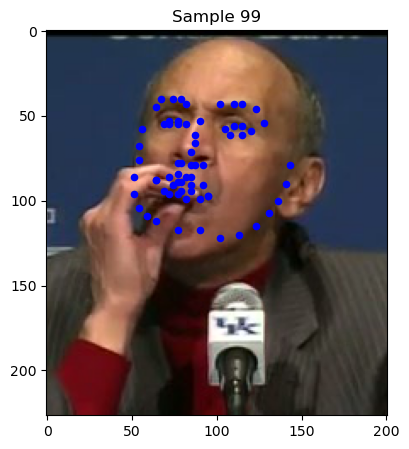

In [5]:
# Display different images by changing the index
index = 99

image_name = key_points_frame.iloc[index, 0]
key_points = key_points_frame.iloc[index, 1:].to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

plt.figure(figsize=(5,5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_points)
plt.title(f'Sample {index}')
plt.show()

# Dataset

In [7]:
class FaceKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_points_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.key_points_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_points_frame.iloc[idx, 0])
        image = mpimg.imread(image_name)

        if image.ndim == 2:
            image = np.stack((image,) * 3, axis=-1)
        elif image.shape[2] == 4:
            image = image[:, :, :3]
            
        key_points = self.key_points_frame.iloc[idx, 1:].to_numpy()
        key_points = key_points.astype('float').reshape(-1, 2)

        sample = {'image': image, 'keypoints': key_points}

        if self.transform:
            sample = self.transform(sample)
     
        return sample


# Transformations

In [9]:
class RandomRotation(object):
    """Randomly rotate the image."""

    def __init__(self, degrees=90):
        self.degrees = degrees

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        angle = random.uniform(-self.degrees, self.degrees)
        rotation_mat = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        rotated_image = cv2.warpAffine(image, rotation_mat, (image.shape[1], image.shape[0]))
        ones = np.ones(shape=(len(key_points), 1))
        points_ones = np.hstack([key_points, ones])
        transformed_keypoints = rotation_mat.dot(points_ones.T).T
        return {'image': rotated_image, 'keypoints': transformed_keypoints}

class AddNoise(object):
    """Add random noise to the image."""

    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        noise = np.random.normal(scale=self.noise_level, size=image.shape)
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, 0, 255)
        return {'image': noisy_image.astype(np.uint8), 'keypoints': key_points}

class Normalize(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        return {'image': image / 255.0, 'keypoints': key_points / [w, h]}

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        key_points = key_points * [new_w / w, new_h / h]
        return {'image': img, 'keypoints': key_points}

class ToTensor(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(key_points)}

class RandomBrightnessContrast(object):
    def __init__(self, brightness=0.2, contrast=0.2):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        brightness_factor = 1.0 + random.uniform(-self.brightness, self.brightness)
        contrast_factor = 1.0 + random.uniform(-self.contrast, self.contrast)
        image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=brightness_factor * 50)
        return {'image': image, 'keypoints': key_points}

class RandomScale(object):
    def __init__(self, scale_range=(0.8, 1.2)):
        self.scale_range = scale_range

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        scale = random.uniform(*self.scale_range)
        new_h, new_w = int(h * scale), int(w * scale)
        image = cv2.resize(image, (new_w, new_h))
        key_points = key_points * [new_w / w, new_h / h]
        return {'image': image, 'keypoints': key_points}

class RandomHorizontalFlip(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if random.random() > 0.5:
            image = np.fliplr(image).copy()
            key_points[:, 0] = image.shape[1] - key_points[:, 0]
        return {'image': image, 'keypoints': key_points}

class RandomVerticalFlip(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if random.random() > 0.5:
            image = np.flipud(image).copy()
            key_points[:, 1] = image.shape[0] - key_points[:, 1]
        return {'image': image, 'keypoints': key_points}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left: left + new_w]
        key_points = key_points - [left, top]
        return {'image': image, 'keypoints': key_points}

In [8]:
# Transforms for training data with augmentations
train_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop((224, 224)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(degrees=30),
    AddNoise(noise_level=5),
    RandomBrightnessContrast(),
    RandomScale(),
    Normalize(),
    ToTensor()
])

# Transforms for validation and test data (without augmentations)
test_transform = transforms.Compose([
    Rescale((224, 224)),
    Normalize(),
    ToTensor()
])

# Datasets and DataLoaders

In [10]:
# Create the full dataset
full_dataset = FaceKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/', transform=None)

# Split the dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=26)

# Create training and validation subsets
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)


# Apply transforms to the training and validation subsets
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform


# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Create the test dataset and DataLoader
test_dataset = FaceKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
